In [79]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner
import scipy
import astropy.units as u

In [80]:
columns=['name','redshift','distance_mod','DM_err','SN_prob']
rawdat=pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\s',names=columns, header=5, engine='python')

In [81]:
data=np.sort(rawdat.T, axis=0)
zs = rawdat.redshift
mm = rawdat.distance_mod
dm = rawdat.DM_err

In [82]:
from scipy import integrate

In [83]:
def DM(z,H0,Om,OL,Ok):
    dz = 0.001
    zz = np.arange(dz,2.0,dz)
    Ok=1-Om-OL
    c = 299792.*1.e6
    Ezz= lambda zz: np.sqrt((Om*(1+zz)**3.)+(Ok*(1+zz)**2.)+OL)
    DL= (c*(1+z)/H0)*integrate.quad(Ezz, 0, z)
    mag=5*np.log10(((DL/10)*u.pc).decompose())
    return mag

In [84]:
p = lmfit.Parameters()
p.add_many(('Om',0.3,True,0,2),('H0',70,True,50,100),('OL',0.7,True,0,2),('Ok',0,True,0,1))

def residual(p):
    v = p.valuesdict()
    return (DM(zs,v['H0'],v['Om'],v['OL'],v['Ok'])-mm)/dm

In [85]:
print p

Parameters([('Om', <Parameter 'Om', 0.3, bounds=[0:2]>), ('H0', <Parameter 'H0', 70, bounds=[50:100]>), ('OL', <Parameter 'OL', 0.7, bounds=[0:2]>), ('Ok', <Parameter 'Ok', 0, bounds=[0:1]>)])


In [86]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

NameError: name 'mi' is not defined

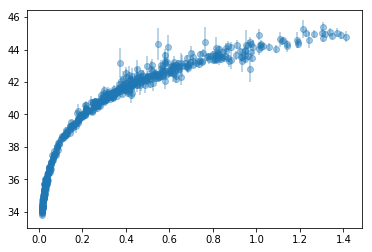

In [87]:
s = (zs.sort_values()).index
plt.errorbar(zs[s],mm[s],yerr=dm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
bestOL =mi.params.valuesdict()['OL']
bestOk=mi.params.valuedict()['Ok']
plt.plot(zs[s],DM(zs[s],bestH0,bestOm ,bestOL,bestOk))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag)')
lmfit.report_fit(mi)

In [ ]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=600, steps=5000, thin=1,
                           params=mi.params)

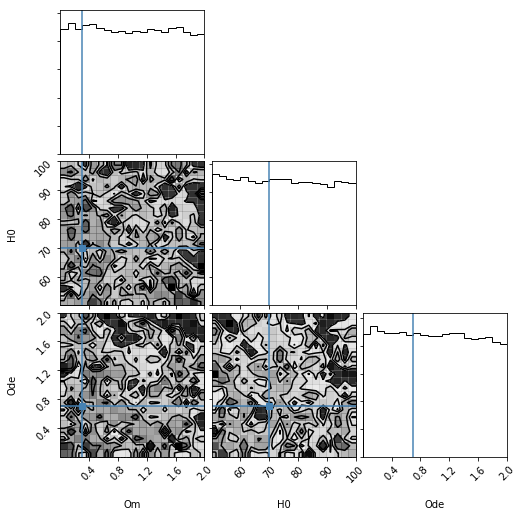

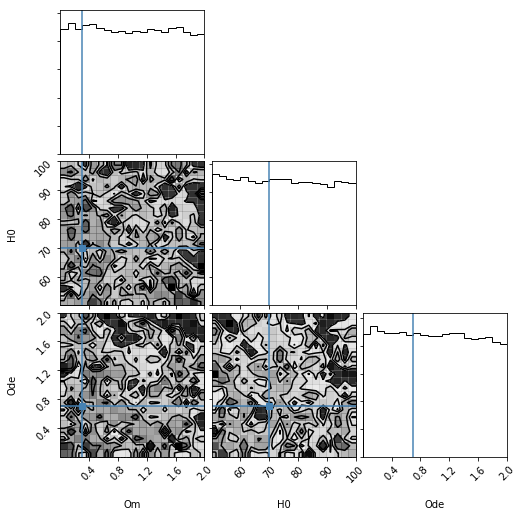

In [16]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))